In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

# Loading the dataset
df = pd.read_csv("/content/Duplicate Annontation data.csv")

# Transforming the labels from -2 to +2 scale to 0 to 4 scale
df['transformed_label'] = df['sentiment_score'] + 2

In [ ]:
# Importing necessary libraries for fine-tuning DistilBERT
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
import pandas as pd
from sklearn.model_selection import train_test_split
import torch


In [ ]:
# Initializing a DistilBERT tokenizer by loading the 'distilbert-base-uncased' pre-trained model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Path to the saved model and tokenizer
model_path = "/content/drive/MyDrive/MyModelFolder"

# Reloading the tokenizer and model
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)

# If GPU is available:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
import pandas as pd
import numpy as np
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
from torch.utils.data import DataLoader, Dataset
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

In [ ]:
"""
Custom dataset class 'SentimentDataset' for handling text and label data.
It uses a tokenizer to encode text inputs with specified settings such as max length, padding, and attention masks.
Implements the __len__ and __getitem__ methods to enable an easy integration with PyTorch DataLoader for sentiment analysis tasks.
"""

class SentimentDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }


In [ ]:
# First split: Separating training set and a temporary set (combining validation and test)
train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)

# Second split: Separating the temporary set into validation and test sets
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

In [ ]:
train_dataset = SentimentDataset(
    train_df['text_with_context'].to_numpy(),
    train_df['transformed_label'].to_numpy(),
    tokenizer,
    max_len=196
)

val_dataset = SentimentDataset(
    val_df['text_with_context'].to_numpy(),
    val_df['transformed_label'].to_numpy(),
    tokenizer,
    max_len=196
)


In [ ]:
test_dataset = SentimentDataset(
    test_df['text_with_context'].to_numpy(),
    test_df['transformed_label'].to_numpy(),
    tokenizer,
    max_len=196
)

test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [ ]:
# Putting the model in evaluation mode
model.eval()

# Initializing lists to store predictions and true labels
test_predictions, test_true_labels = [], []

# Evaluating the model
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        test_predictions.extend(logits)
        test_true_labels.extend(label_ids)

# Converting logits to actual predictions
test_predictions = np.argmax(test_predictions, axis=1)

# Calculating accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test_true_labels, test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='weighted')

print(f'Test Accuracy: {accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1 Score: {f1}')


Test Accuracy: 0.5081967213114754
Test Precision: 0.5807943690296631
Test Recall: 0.5081967213114754
Test F1 Score: 0.5208188603217688


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Specifying number of splits for cross-validation
n_splits = 3

# Initializing KFold
kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# Converting DataFrame columns to numpy for indexing in KFold
texts = train_df['text_with_context'].to_numpy()
text_labels = train_df['transformed_label'].to_numpy()

In [ ]:
def create_data_loader(dataset, batch_size):
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
print("Size of texts:", len(texts))
print("Size of labels:", len(text_labels))


Size of texts: 282
Size of labels: 282


In [ ]:
"""
Evaluates the performance of a given 'model' on a validation set provided by 'val_loader' using the specified 'device'.
Computes accuracy, precision, recall, and F1 score.
"""


def evaluate_model_on_fold(model, val_loader, device):
    model.eval()
    predictions, true_text_labels = [], []

    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask)
            logits = outputs.logits

            logits = logits.detach().cpu().numpy()
            label_ids = labels.to('cpu').numpy()

            predictions.append(logits)
            true_text_labels.append(label_ids)

    predictions = np.argmax(np.concatenate(predictions, axis=0), axis=1)
    true_text_labels = np.concatenate(true_text_labels, axis=0)

    accuracy = accuracy_score(true_text_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_text_labels, predictions, average='weighted')

    return accuracy, precision, recall, f1

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


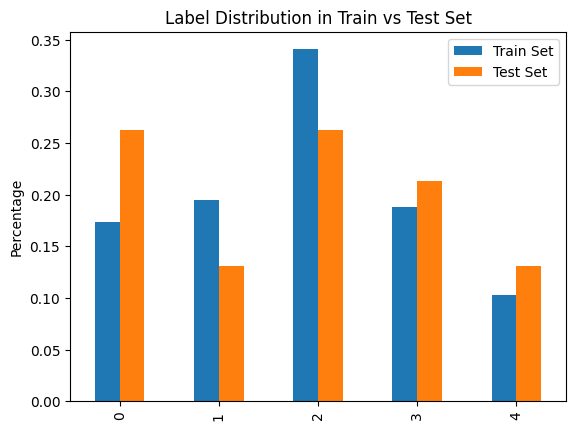

In [ ]:
# Computing normalized label distributions for training and test sets

train_label_distribution = train_df['transformed_label'].value_counts(normalize=True)
test_label_distribution = test_df['transformed_label'].value_counts(normalize=True)

# Creating a DataFrame for easier comparison
label_distribution_comparison = pd.DataFrame({'Train Set': train_label_distribution,
                                              'Test Set': test_label_distribution})

# Plotting
label_distribution_comparison.plot(kind='bar')
plt.title('Label Distribution in Train vs Test Set')
plt.ylabel('Percentage')
plt.show()


In [ ]:
from sklearn.model_selection import StratifiedKFold

In [ ]:
# Specifying of splits for cross-validation
n_splits = 3

# Initializing StratifiedKFold
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

# Converting DataFrame columns to numpy for indexing in StratifiedKFold
texts = train_df['text_with_context'].to_numpy()
text_labels = train_df['transformed_label'].to_numpy()

# Preparing to collect metrics
cv_accuracy, cv_precision, cv_recall, cv_f1 = [], [], [], []

for train_index, val_index in skf.split(texts, text_labels):
    train_texts, val_texts = texts[train_index], texts[val_index]
    train_text_labels, val_text_labels = text_labels[train_index], text_labels[val_index]

    train_dataset = SentimentDataset(train_texts, train_text_labels, tokenizer, max_len=196)
    val_dataset = SentimentDataset(val_texts, val_text_labels, tokenizer, max_len=196)
    train_loader = create_data_loader(train_dataset, batch_size=16)
    val_loader = create_data_loader(val_dataset, batch_size=16)

    model = DistilBertForSequenceClassification.from_pretrained(model_path)
    model.to(device)
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    for epoch in range(3):
        model.train()
        for batch in train_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluating the model on the validation set
    accuracy, precision, recall, f1 = evaluate_model_on_fold(model, val_loader, device)
    cv_accuracy.append(accuracy)
    cv_precision.append(precision)
    cv_recall.append(recall)
    cv_f1.append(f1)

# Calculating average metrics across all folds
avg_accuracy = np.mean(cv_accuracy)
avg_precision = np.mean(cv_precision)
avg_recall = np.mean(cv_recall)
avg_f1 = np.mean(cv_f1)

print(f"Average Accuracy: {avg_accuracy}")
print(f"Average Precision: {avg_precision}")
print(f"Average Recall: {avg_recall}")
print(f"Average F1 Score: {avg_f1}")


Average Accuracy: 0.9113475177304964
Average Precision: 0.9153611627328774
Average Recall: 0.9113475177304964
Average F1 Score: 0.9100735485268571


In [ ]:
model.eval()


DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Generating predictions and true labels for the test set using the trained model

test_predictions, test_true_labels = [], []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask)
        logits = outputs.logits

        logits = logits.detach().cpu().numpy()
        label_ids = labels.to('cpu').numpy()

        test_predictions.extend(logits)
        test_true_labels.extend(label_ids)

# Converting logits to actual predictions
test_predictions = np.argmax(test_predictions, axis=1)


In [ ]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculating accuracy, precision, recall, and F1 score
accuracy = accuracy_score(test_true_labels, test_predictions)
precision, recall, f1, _ = precision_recall_fscore_support(test_true_labels, test_predictions, average='weighted')

print(f'Test Accuracy: {accuracy}')
print(f'Test Precision: {precision}')
print(f'Test Recall: {recall}')
print(f'Test F1 Score: {f1}')


Test Accuracy: 0.5573770491803278
Test Precision: 0.6012584865043882
Test Recall: 0.5573770491803278
Test F1 Score: 0.5741040160671689


In [ ]:
import pandas as pd

# Creating an error analysis DataFrame with the original text and context from the test set, along with true and predicted labels.

error_analysis_df = test_df[['text_with_context']].copy()
error_analysis_df['True_Label'] = test_true_labels
error_analysis_df['Predicted_Label'] = test_predictions


In [ ]:
incorrect_predictions_df = error_analysis_df[error_analysis_df['True_Label'] != error_analysis_df['Predicted_Label']]


In [ ]:
# Analyzing errors by class
errors_by_class = incorrect_predictions_df.groupby('True_Label').count()
print(errors_by_class)

# Analyzing errors by text length
incorrect_predictions_df['Text_Length'] = incorrect_predictions_df['text_with_context'].apply(len)
print(incorrect_predictions_df['Text_Length'].describe())


            text_with_context  Predicted_Label
True_Label                                    
0                           5                5
1                           6                6
2                           6                6
3                           6                6
4                           4                4
count      27.000000
mean      408.481481
std       276.191735
min       130.000000
25%       193.000000
50%       263.000000
75%       585.500000
max      1056.000000
Name: Text_Length, dtype: float64


<ipython-input-52-d9b35edc2bda>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  incorrect_predictions_df['Text_Length'] = incorrect_predictions_df['text_with_context'].apply(len)


In [ ]:
# Randomly sampling some incorrect predictions for manual review
print(incorrect_predictions_df.sample(n=20))


                                     text_with_context  True_Label  \
278  Unbearable Pain w/ No Relief [SEP] i also have...           2   
77   Feeling lousy after methotrexate injection [SE...           0   
131  Will i have my hands back? [SEP] that is heart...           0   
180  Starting Rinvoq - Tell me the good & bad pleas...           4   
331  Starting methotrexate next week [SEP] methotre...           4   
192  Diagnosed with seronegative RA but something s...           3   
275  I need suggestions for Rheumatoid Arthritis pa...           3   
364  How long does it take for the effects of junky...           2   
76   How to deal with the blues? [SEP] how long has...           1   
9    I'm seeking advice for managing Rheumatoid Art...           0   
282  How long does it take for the effects of junky...           2   
265  How risky would flying long-distance be, takin...           2   
392  Best Collagen Supplement or others for hair lo...           2   
45   Low mood - meth

In [ ]:
import pandas as pd

# Loading the main dataset for sentiment prediction
large_df = pd.read_csv('/content/drive/MyDrive/validation_data.csv')  # Replace with your actual file path

In [ ]:
from torch.utils.data import DataLoader

class LargeDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len):
        self.texts = texts
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten()
        }

# Creating a dataset for the larger dataset
large_dataset = LargeDataset(large_df['text_with_context'], tokenizer, max_len=196)


large_dataset = LargeDataset(large_df['text_with_context'], tokenizer, max_len=196)
batch_size = 32
large_loader = DataLoader(large_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Applying the trained model to the main dataset, saving backups periodically and printing progress updates. Handling batch processing errors, too.

import torch

model.eval()
large_predictions = []
total_batches = len(large_loader)
processed_batches = 0
backup_interval = 100  # Defining the interval for backups

try:
    with torch.no_grad():
        for batch in large_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)

            try:
                outputs = model(input_ids, attention_mask)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                large_predictions.extend(preds.cpu().numpy())
            except Exception as e:
                print(f"Error processing batch: {e}")

            processed_batches += 1
            if processed_batches % backup_interval == 0:
                # Saving a backup of the predictions progressively
                temp_df = large_df.iloc[:processed_batches * batch_size].copy()
                temp_df['predicted_sentiment'] = large_predictions[:processed_batches * batch_size]
                temp_df.to_csv('/content/drive/MyDrive/temp_predictions_backup.csv', index=False)
                print(f"Backup saved after processing {processed_batches} batches.")

            if processed_batches % 10 == 0:  # Printing progress every 10 batches
                print(f"Processed {processed_batches}/{total_batches} batches.")
except Exception as e:
    print(f"An error occurred during model application: {e}")

Processed 10/159 batches.
Processed 20/159 batches.
Processed 30/159 batches.
Processed 40/159 batches.
Processed 50/159 batches.
Processed 60/159 batches.
Processed 70/159 batches.
Processed 80/159 batches.
Processed 90/159 batches.
Backup saved after processing 100 batches.
Processed 100/159 batches.
Processed 110/159 batches.
Processed 120/159 batches.
Processed 130/159 batches.
Processed 140/159 batches.
Processed 150/159 batches.


In [ ]:
# Saving the final predictions
large_df['predicted_sentiment'] = large_predictions
output_file = '/content/drive/MyDrive/final2_predictions.csv'
large_df.to_csv(output_file, index=False)

In [ ]:
import pandas as pd

# Replacing with the path with the CSV file containing the predictions
predictions_file = '/content/drive/MyDrive/final2_predictions.csv'
df = pd.read_csv(predictions_file)


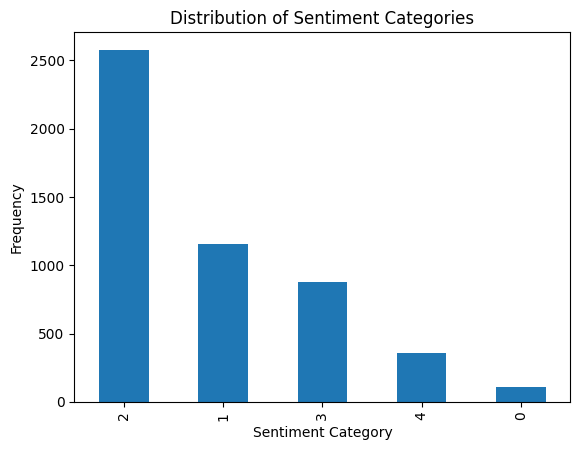

In [ ]:
# Plotting a bar chart to visualize the distribution of predicted sentiment categories

import matplotlib.pyplot as plt


sentiment_counts = df['predicted_sentiment'].value_counts()
sentiment_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Categories')
plt.xlabel('Sentiment Category')
plt.ylabel('Frequency')
plt.show()

In [ ]:
# calculating the percentage of each sentiment category
sentiment_percentage = df['predicted_sentiment'].value_counts(normalize=True) * 100
print(sentiment_percentage)

2    50.798030
1    22.837438
3    17.280788
4     6.995074
0     2.088670
Name: predicted_sentiment, dtype: float64


In [ ]:
#Specifying a sample size for manual review
sample_size = 100
validation2_sample = df.sample(n=sample_size, random_state=42)

In [ ]:
validation2_sample.to_csv('/content/drive/MyDrive/manual_validation2_sample.csv', index=False)

In [ ]:
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report

# Loading the dataset with predicted and manually annotated sentiment scores
df = pd.read_csv('/content/new_manual_validation2_sample.csv')

# Specifying columns containing predicted and manually annotated sentiment scores
predicted_column = 'predicted_sentiment'
manual_column = 'validation_scores'

# Converting the sentiment scores to integers
df[predicted_column] = df[predicted_column].astype(int)
df[manual_column] = df[manual_column].astype(int)

# Calculating metrics
accuracy = accuracy_score(df[manual_column], df[predicted_column])
precision = precision_score(df[manual_column], df[predicted_column], average='weighted')
recall = recall_score(df[manual_column], df[predicted_column], average='weighted')
f1 = f1_score(df[manual_column], df[predicted_column], average='weighted')

# Confusion matrix and classification report
conf_matrix = confusion_matrix(df[manual_column], df[predicted_column])
class_report = classification_report(df[manual_column], df[predicted_column])

# Printing the metrics
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

# Printing confusion matrix and classification report
print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)


Accuracy: 0.46
Precision: 0.46418325791855203
Recall: 0.46
F1 Score: 0.456423011239525
Confusion Matrix:
[[ 0  5  0  1  1]
 [ 1  3 11  3  1]
 [ 0  9 35  9  4]
 [ 0  0  5  6  2]
 [ 0  0  1  1  2]]

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         7
           1       0.18      0.16      0.17        19
           2       0.67      0.61      0.64        57
           3       0.30      0.46      0.36        13
           4       0.20      0.50      0.29         4

    accuracy                           0.46       100
   macro avg       0.27      0.35      0.29       100
weighted avg       0.46      0.46      0.46       100



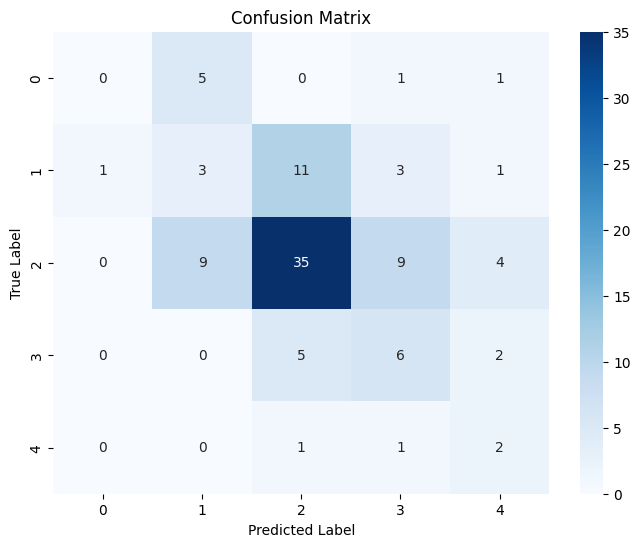

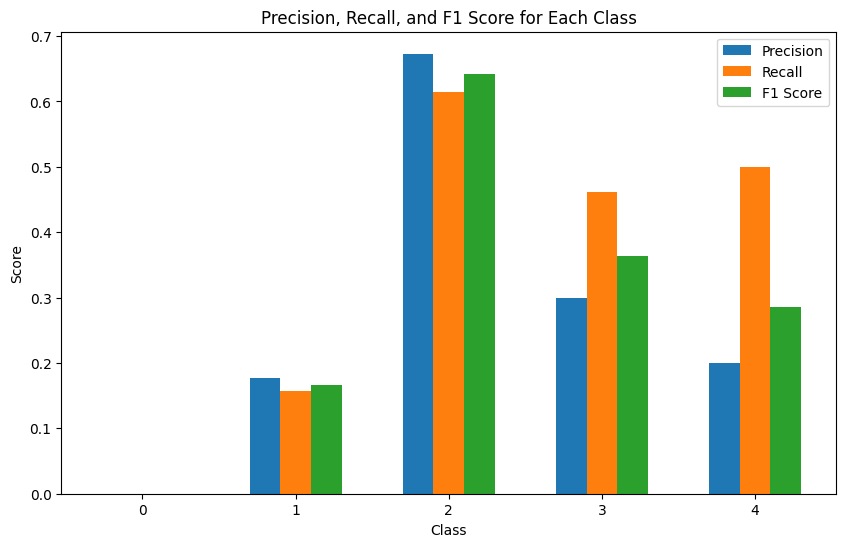

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report


true_labels = df['validation_scores'].astype(int)
predicted_labels = df['predicted_sentiment'].astype(int)

# Plotting Confusion Matrix Heatmap
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Precision, Recall, and F1 Score Bar Chart
metrics = classification_report(true_labels, predicted_labels, target_names=[str(i) for i in range(5)], output_dict=True)
precision = [metrics[str(i)]['precision'] for i in range(5)]
recall = [metrics[str(i)]['recall'] for i in range(5)]
f1 = [metrics[str(i)]['f1-score'] for i in range(5)]

plt.figure(figsize=(10, 6))
bar_width = 0.2
index = range(5)
plt.bar(index, precision, width=bar_width, label='Precision')
plt.bar([i + bar_width for i in index], recall, width=bar_width, label='Recall')
plt.bar([i + 2 * bar_width for i in index], f1, width=bar_width, label='F1 Score')
plt.xlabel('Class')
plt.ylabel('Score')
plt.title('Precision, Recall, and F1 Score for Each Class')
plt.xticks([i + bar_width for i in index], [str(i) for i in range(5)])
plt.legend()
plt.show()



In [ ]:
# Calculating the agreement rate between predicted sentiment labels and validation scores

agreement_rate = (df['predicted_sentiment'] == df['validation_scores']).mean()
print(f"Agreement Rate: {agreement_rate:.2f}")

Agreement Rate: 0.46


In [ ]:
predicted_counts = df['predicted_sentiment'].value_counts()
manual_counts = df['validation_scores'].value_counts()

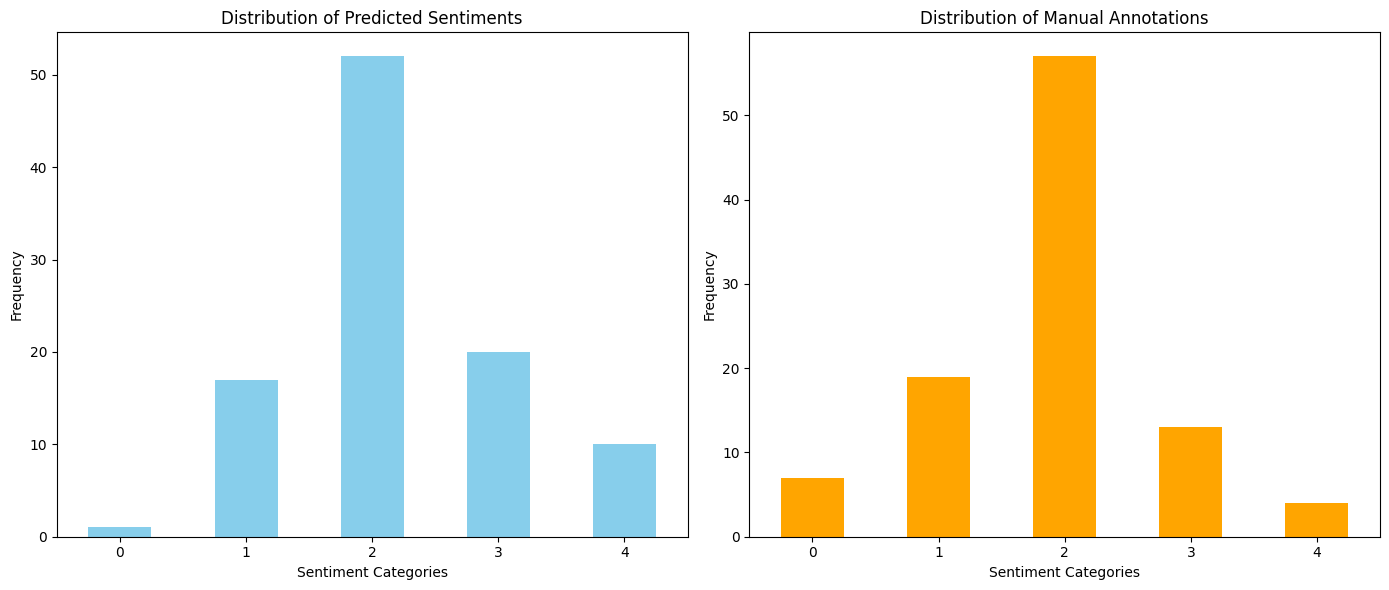

In [ ]:
import matplotlib.pyplot as plt

# Setting up the matplotlib figure
plt.figure(figsize=(14, 6))

# Defining the order for the x-axis ticks
sentiment_order = [0, 1, 2, 3, 4]

# Bar chart for model's predictions
plt.subplot(1, 2, 1)
predicted_counts.loc[sentiment_order].plot(kind='bar', color='skyblue')
plt.title('Distribution of Predicted Sentiments')
plt.xlabel('Sentiment Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

# Bar chart for manual annotations
plt.subplot(1, 2, 2)
manual_counts.loc[sentiment_order].plot(kind='bar', color='orange')
plt.title('Distribution of Manual Annotations')
plt.xlabel('Sentiment Categories')
plt.ylabel('Frequency')
plt.xticks(rotation=0)

plt.tight_layout()
plt.show()


In [ ]:
# Filtering the instances with disagreements
disagreements = df[df['predicted_sentiment'] != df['validation_scores']]

# Analyzing the distribution of disagreements
disagreement_distribution = disagreements['validation_scores'].value_counts()
print(disagreement_distribution)


2    22
1    16
0     7
3     7
4     2
Name: validation_scores, dtype: int64
